In [1]:
%matplotlib inline
import numpy 
import logging
import time
import matplotlib.pyplot as plt
import mxnet as mx
import mxnet.ndarray as nd

In this notebook, we will show how to replicate the toy example in the paper (Welling and Teh, 2011). Here we have observed 20 instances from a mixture of Gaussians with tied means: $$
\begin{aligned}
\theta_1 &\sim N(0, \sigma_1^2)\\
\theta_2 &\sim N(0, \sigma_2^2)\\
x_i &\sim \frac{1}{2}N(0, \sigma_x^2) + \frac{1}{2}N(\theta_1 + \theta_2, \sigma_x^2)
\end{aligned}
$$ We are asked to draw samples from the posterior distribution $p(\theta_1, \theta_2 \mid X)$. In the following, we will use stochastic gradient langevin dynamics (SGLD) to do the sampling.

In [2]:
def load_synthetic(theta1, theta2, sigmax, num=20):
    flag = numpy.random.randint(0, 2, (num,))
    X = flag * numpy.random.normal(theta1, sigmax, (num, )) \
                    + (1.0 - flag) * numpy.random.normal(theta1 + theta2, sigmax, (num, ))
    return X.astype('float32')


class SGLDScheduler(mx.lr_scheduler.LRScheduler):
    def __init__(self, begin_rate, end_rate, total_iter_num, factor):
        super(SGLDScheduler, self).__init__()
        if factor >= 1.0:
            raise ValueError("Factor must be less than 1 to make lr reduce")
        self.begin_rate = begin_rate
        self.end_rate = end_rate
        self.total_iter_num = total_iter_num
        self.factor = factor
        self.b = (total_iter_num - 1.0) / ((begin_rate / end_rate) ** (1.0 / factor) - 1.0)
        self.a = begin_rate / (self.b ** (-factor))
        self.count = 0

    def __call__(self, num_update):
        self.base_lr = self.a * ((self.b + num_update) ** (-self.factor))
        self.count += 1
        return self.base_lr


def synthetic_grad(X, theta, sigma1, sigma2, sigmax, rescale_grad=1.0, grad=None):
    if grad is None:
        grad = nd.empty(theta.shape, theta.context)
    theta1 = theta.asnumpy()[0]
    theta2 = theta.asnumpy()[1]
    v1 = sigma1 **2
    v2 = sigma2 **2
    vx = sigmax **2
    denominator = numpy.exp(-(X - theta1)**2/(2*vx)) + numpy.exp(-(X - theta1 - theta2)**2/(2*vx))
    grad_npy = numpy.zeros(theta.shape)
    grad_npy[0] = -rescale_grad*((numpy.exp(-(X - theta1)**2/(2*vx))*(X - theta1)/vx
                + numpy.exp(-(X - theta1 - theta2)**2/(2*vx))*(X - theta1-theta2)/vx)/denominator).sum()\
                + theta1/v1
    grad_npy[1] = -rescale_grad*((numpy.exp(-(X - theta1 - theta2)**2/(2*vx))*(X - theta1-theta2)/vx)/denominator).sum()\
                + theta2/v2
    grad[:] = grad_npy
    return grad

We first write the generation process. In the paper, the data instances are generated with the following parameter, $\theta_1^2=10, \theta_2^2=1, \theta_x^2=2$. Also, we need to write a new learning rate schedule as described in the paper $\epsilon_t = a(b+t)^{-r}$ and calculate the gradient. After these preparations, we can go on with the sampling process.

In [4]:
numpy.random.seed(100)
mx.random.seed(100)

theta1 = 0
theta2 = 1
sigma1 = numpy.sqrt(10)
sigma2 = 1
sigmax = numpy.sqrt(2)
X = load_synthetic(theta1=theta1, theta2=theta2, sigmax=sigmax, num=100)
minibatch_size = 1
total_iter_num = 1000000
lr_scheduler = SGLDScheduler(begin_rate=0.01, end_rate=0.0001, total_iter_num=total_iter_num,
                             factor=0.55)
optimizer = mx.optimizer.create('sgld',
                        learning_rate=None,
                        rescale_grad=1.0,
                        lr_scheduler=lr_scheduler,
                        wd=0)
updater = mx.optimizer.get_updater(optimizer)
theta = mx.random.normal(0, 1, (2,), mx.cpu())
grad = nd.empty((2,), mx.cpu())
samples = numpy.zeros((2, total_iter_num))
start = time.time()
for i in range(total_iter_num):
    if (i+1)%100000 == 0:
        end = time.time()
        print ('Iter:{:d}, Time spent: {:f}'.format(i + 1, end-start))
        start = time.time()
    ind = numpy.random.randint(0, X.shape[0])
    synthetic_grad(X[ind], theta, sigma1, sigma2, sigmax, rescale_grad=
                            X.shape[0] / float(minibatch_size), grad=grad)
    updater('theta', grad, theta)
    samples[:, i] = theta.asnumpy()

Iter:100000, Time spent: 46.720259
Iter:200000, Time spent: 45.771719
Iter:300000, Time spent: 45.647488
Iter:400000, Time spent: 45.431172
Iter:500000, Time spent: 46.300978
Iter:600000, Time spent: 45.362901
Iter:700000, Time spent: 45.834905
Iter:800000, Time spent: 45.372222
Iter:900000, Time spent: 46.491635
Iter:1000000, Time spent: 46.466730


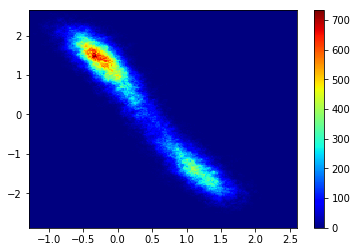

In [5]:
plt.hist2d(samples[0, :], samples[1, :], (200, 200), cmap=plt.cm.jet)
plt.colorbar()
plt.show()